In [1]:
import json
import csv

import numpy as np
import matplotlib.pyplot as plt
import torch
import copy
import math
import pickle
import sys
sys.path.append("../../")

import implicitmodules.torch as dm

In [2]:

torch.set_default_dtype(torch.float64)

In [3]:
path_datafiles = '/home/gris/Data/2DShapes/'
path_names = path_datafiles + 'NamesPLAINTEXT/'

names = []
with open(path_names + 'labels.txt', 'r') as namelist:
    for line in namelist:
        names.append(line[:-1])

In [4]:
ind_shape = 21

names_subj = []
with open(path_names + 'ShapeNames/' + names[ind_shape] + '.txt', 'r') as namelist:
    for line in namelist:
        names_subj.append(line[:-1])


In [5]:
ind_subj = 0
path_subj = path_datafiles + 'ShapesJSON/Shapes/' + names_subj[ind_subj] + '.json'
#subj = 

In [6]:
list_subj = []
list_indi_tri = []
list_majo = []
for ind_subj in range(len(names_subj)):
    path_subj = path_datafiles + 'ShapesJSON/Shapes/' + names_subj[ind_subj] + '.json'
    with open(path_subj) as f:
        subj_dict = json.load(f)
        Npts = len(subj_dict['points'])
        subj = []
        for i in range(Npts-1):
            subj.append([subj_dict['points'][i]['x'], subj_dict['points'][i]['y']])

        list_subj.append(np.array(subj))
        
        indi_tri = []
        Ntri = len(subj_dict['triangles'])
        for i in range(Ntri):
            indi_tri.append([subj_dict['triangles'][i]['p1'],subj_dict['triangles'][i]['p2'],subj_dict['triangles'][i]['p3']])
        list_indi_tri.append(np.array(indi_tri))
     
    path_majo = path_datafiles + 'MajorityJSON/Majority/' + names_subj[ind_subj] + '.json'
    with open(path_majo) as f:
        list_majo.append(json.load(f))

FileNotFoundError: [Errno 2] No such file or directory: '/home/gris/Data/2DShapes/MajorityJSON/Majority/tree-19.json'

(-0.032553, 0.683613, -0.05, 1.05)

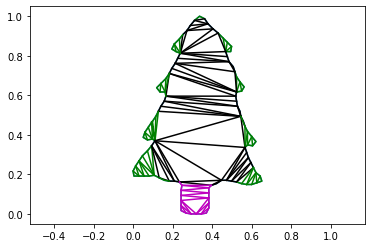

In [7]:
ind_subj = 4
subj = list_subj[ind_subj]
indi_tri = list_indi_tri[ind_subj]
majo_dict = list_majo[ind_subj]

col = ['k', 'm', 'g']
plt.plot(subj[:,0], subj[:,1])
for i in range(np.shape(indi_tri)[0]):
    plt.plot(subj[indi_tri[i],0], subj[indi_tri[i],1], col[majo_dict['majority'][i]])
    t1 = plt.Polygon(subj[indi_tri[i],:], color=col[majo_dict['majority'][i]])
    #plt.gca().add_patch(t1)
plt.axis('equal')

(-0.0353095, 0.7414995, -0.05, 1.05)

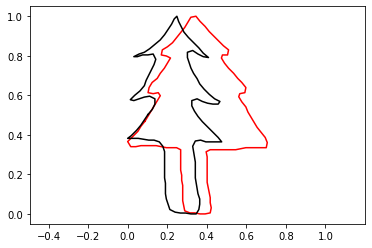

In [8]:
ind_subj_source = 0
subj = list_subj[ind_subj_source]
indi_tri = list_indi_tri[ind_subj_source]
majo_dict = list_majo[ind_subj_source]
plt.plot(subj[:,0], subj[:,1], '-r')

ind_subj_target = 7
subj = list_subj[ind_subj_target]
indi_tri = list_indi_tri[ind_subj_target]
majo_dict = list_majo[ind_subj_target]
plt.plot(subj[:,0], subj[:,1],'k')

plt.axis('equal')

In [9]:
source = torch.tensor(list_subj[ind_subj_source])
target = torch.tensor(list_subj[ind_subj_target])

# Matching with LDDMM

In [35]:
source_deformable = dm.Models.DeformablePoints(source)
target_deformable = dm.Models.DeformablePoints(target)

In [36]:
sigma = 0.05
translations = dm.DeformationModules.ImplicitModule0(2, source.shape[0], sigma, nu=0.1, gd=source.clone().requires_grad_())

In [37]:
sigmas_varifold = [0.1, 1.]
attachment = dm.Attachment.VarifoldAttachment(2, sigmas_varifold)

In [38]:
# model = dm.Models.RegistrationModel([source_deformable], [rotation], [dm.Attachment.GeomlossAttachment(loss='sinkhorn', blur=0.05, scaling=0.9)], fit_gd=[True], lam=100.)
model = dm.Models.RegistrationModel([source_deformable], [translations], [attachment], fit_gd=[False], lam=100.)

In [39]:
shoot_solver = 'euler'
shoot_it = 10

costs = {}
fitter = dm.Models.Fitter(model, optimizer='torch_lbfgs')
# fitter = dm.Models.Fitter(model, optimizer='scipy_l-bfgs-b')
fitter.fit([target_deformable], 20, costs=costs, options={'shoot_solver': shoot_solver, 'shoot_it': shoot_it, 'line_search_fn': 'strong_wolfe'})


Starting optimization with method torch LBFGS
Initial cost={'deformation': tensor(0.), 'attach': tensor(233.5006)}
Time: 9.287180518999776
Iteration: 0
Costs
deformation=0.2329261466173373
attach=4.6218243801744885
Total cost=4.854750526791825
Time: 18.713974557000256
Iteration: 1
Costs
deformation=0.14788727814267122
attach=1.0024849016317283
Total cost=1.1503721797743995
Time: 28.79587614800039
Iteration: 2
Costs
deformation=0.09322841496231607
attach=0.4215177731317965
Total cost=0.5147461880941125
Time: 39.28441695699985
Iteration: 3
Costs
deformation=0.06902554650571996
attach=0.30381490590067894
Total cost=0.3728404524063989
Time: 49.15749884199977
Iteration: 4
Costs
deformation=0.04990014023038772
attach=0.280512956847212
Total cost=0.3304130970775997
Time: 59.31317231100002
Iteration: 5
Costs
deformation=0.02405354377110054
attach=0.2530823433720908
Total cost=0.2771358871431913
Time: 69.78154982100023
Iteration: 6
Costs
deformation=0.017800682869175126
attach=0.234150300110114

KeyboardInterrupt: 

In [40]:
intermediates = {}
with torch.autograd.no_grad():
    deformed_source = model.compute_deformed(shoot_solver, shoot_it, intermediates=intermediates)[0][0]


(-0.05, 1.05, -0.09062353202540636, 1.0519344539059716)

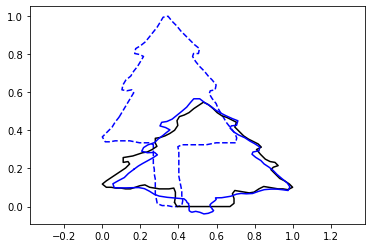

In [48]:
plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], '--b')
plt.plot(target.detach().numpy()[:,0], target.detach().numpy()[:,1], 'k')
plt.plot(deformed_source.detach().numpy()[:,0], deformed_source.detach().numpy()[:,1], 'b')
plt.axis('equal')

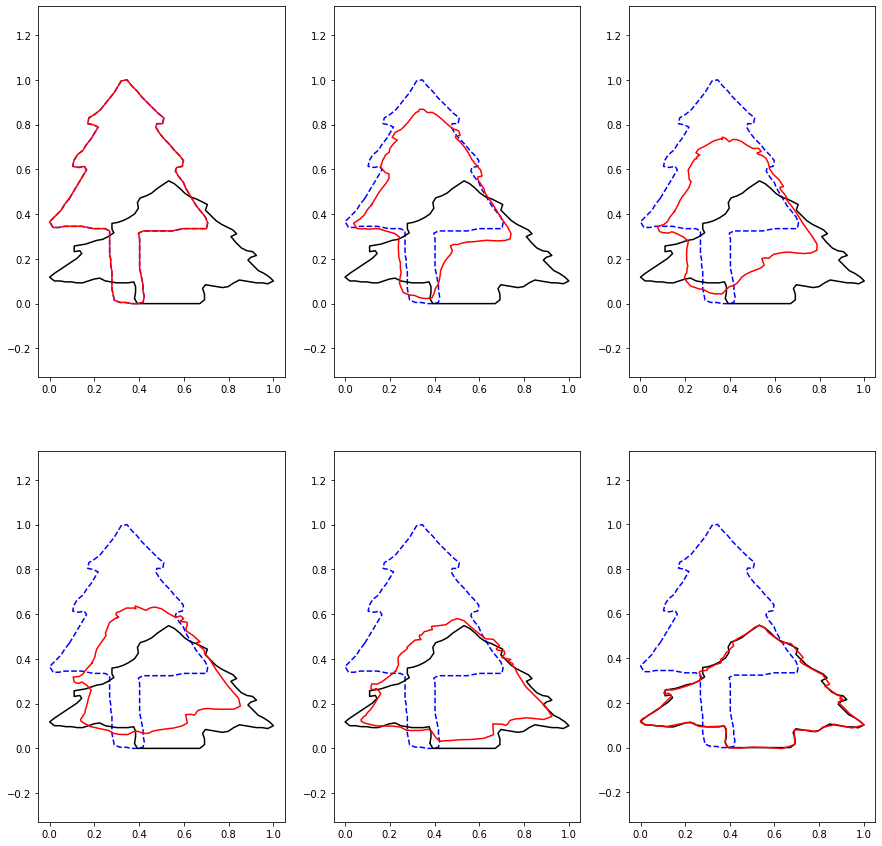

In [42]:
f = plt.figure(figsize=(15,15))
for i in range(6):
    ax = f.add_subplot(2,3,i+1)
    plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], '--b')
    plt.plot(target.detach().numpy()[:,0], target.detach().numpy()[:,1], 'k')
    plt.plot(intermediates['states'][2*i].gd[0].detach().numpy()[:,0], intermediates['states'][2*i].gd[0].detach().numpy()[:,1], 'r')
    plt.axis('equal')

# Matching with growth model

In [10]:
aabb = dm.Utilities.aabb.AABB.build_from_points(source)

In [11]:
aabb.scale_([1.5, 2])

In [12]:
aabb_source = dm.Utilities.AABB.build_from_points(source)
density = 300
points_growth = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_source, density, shape=source)


In [13]:
points_growth.shape

torch.Size([96, 2])

(-0.0353095, 0.7414995, -0.05, 1.05)

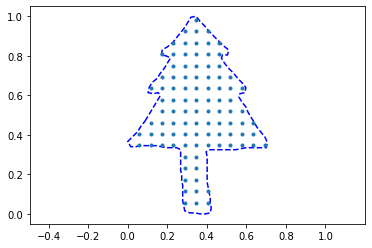

In [14]:
plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], '--b')
plt.plot(points_growth[:,0], points_growth[:,1], '.')
plt.axis('equal')

(-0.0353095, 0.7414995, -0.05, 1.05)

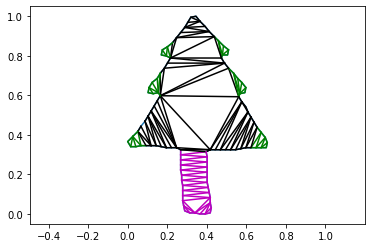

In [15]:
subj = list_subj[ind_subj_source]
indi_tri = list_indi_tri[ind_subj_source]
majo_dict = list_majo[ind_subj_source]

col = ['k', 'm', 'g']
plt.plot(subj[:,0], subj[:,1])
for i in range(np.shape(indi_tri)[0]):
    plt.plot(subj[indi_tri[i],0], subj[indi_tri[i],1], col[majo_dict['majority'][i]])
    t1 = plt.Polygon(subj[indi_tri[i],:], color=col[majo_dict['majority'][i]])
    #plt.gca().add_patch(t1)
plt.axis('equal')

In [16]:
source.shape

torch.Size([112, 2])

In [17]:
indi_top0 = range(0, 67)
indi_top1 = range(97, 112)
#indi_left0 = range(0, 28)
#indi_left1 = range(80, 104)
indi_bottom = range(67, 97)


part_top = np.concatenate([source[indi_top0, :], source[indi_top1, :]], axis = 0)
#part_top = source[indi_left, :]
part_bottom = source[indi_bottom, :]

(-0.0353095, 0.7414995, -0.05, 1.05)

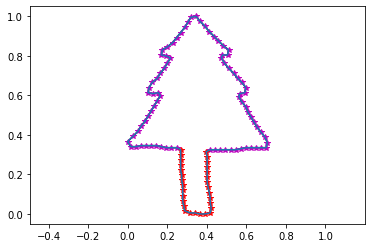

In [18]:
plt.plot(source[:,0], source[:,1], 'k')
plt.plot(part_top[:,0], part_top[:,1], '*m')
plt.plot(part_bottom[:,0], part_bottom[:,1], '*r')

col = ['k', 'm', 'g']
plt.plot(subj[:,0], subj[:,1])
#for i in range(np.shape(indi_tri)[0]):
    #plt.plot(subj[indi_tri[i],0], subj[indi_tri[i],1], col[majo_dict['majority'][i]])
    #t1 = plt.Polygon(subj[indi_tri[i],:], color=col[majo_dict['majority'][i]])
    
plt.axis('equal')

In [19]:
aabb_source = dm.Utilities.AABB.build_from_points(source)
points_growth = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_source, density, shape=source)
points_growthtop = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_source, density, shape=torch.tensor(part_top), intersect=True)
points_growthbottom = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_source, density, shape=torch.tensor(part_bottom), intersect=True)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [20]:
points_growth = aabb_source.scale(1.1).fill_uniform_density(density)

In [21]:
indi_growth_bottom = torch.where(points_growth[:,1] < 0.35)[0]
indi_growth_top = torch.where(points_growth[:,1] >= 0.35)[0]

(-0.07283726749732572,
 0.752773617443839,
 -0.10484827557301449,
 1.1018137870333031)

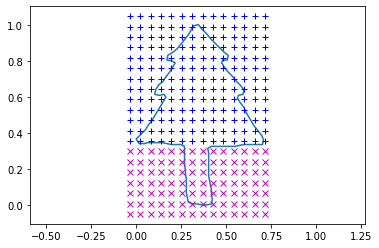

In [22]:

plt.plot(subj[:,0], subj[:,1])

plt.plot(points_growth[indi_growth_top,0], points_growth[indi_growth_top,1], '+b')
plt.plot(points_growth[indi_growth_bottom,0], points_growth[indi_growth_bottom,1], 'xm')
plt.axis('equal')

In [23]:
points_growth = torch.cat([points_growthtop, points_growthbottom])
indi_growth_top = range(0, points_growthtop.shape[0])
indi_growth_bottom = range(points_growthtop.shape[0], points_growthtop.shape[0] + points_growthbottom.shape[0])

In [24]:
aabb_bottom = dm.Utilities.AABB(0.27, 0.43, 0.,0.3)

In [25]:
points_growthbottom = aabb_bottom.scale(1.).fill_uniform_density(200)

In [26]:
points_growth = torch.cat([points_growthtop, points_growthbottom])
indi_growth_top = range(0, points_growthtop.shape[0])
indi_growth_bottom = range(points_growthtop.shape[0], points_growthtop.shape[0] + points_growthbottom.shape[0])

(-0.0353095, 0.7414995, -0.05, 1.05)

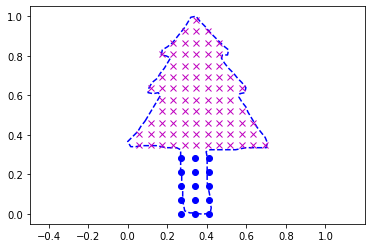

In [27]:
plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], '--b')
plt.plot(points_growthtop[:,0], points_growthtop[:,1], 'xm')
plt.plot(points_growthbottom[:,0], points_growthbottom[:,1], 'ob')
plt.axis('equal')

(-0.0353095, 0.7414995, -0.05, 1.05)

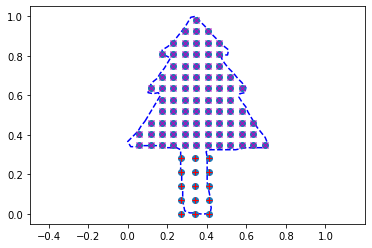

In [33]:
plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], '--b')
plt.plot(points_growth[:,0], points_growth[:,1], 'o')
plt.plot(points_growth[indi_growth_top,0], points_growth[indi_growth_top,1], 'xm')
plt.plot(points_growth[indi_growth_bottom,0], points_growth[indi_growth_bottom,1], '+r')
plt.axis('equal')

In [34]:
#%matplotlib qt5
C = torch.zeros(points_growth.shape[0], 2, 4)
C[indi_growth_top, 0, 0] = 1.
C[indi_growth_top, 1, 1] = 1.
C[indi_growth_bottom, 0, 2] = 1.
C[indi_growth_bottom, 1, 3] = 1.

In [35]:
#%matplotlib qt5
#C = torch.zeros(points_growth.shape[0], 2, 2)
#C[:, 0, 0] = 1.
#C[:, 1, 1] = 1.

In [36]:
C.shape

torch.Size([99, 2, 4])

In [37]:
rot_growth = torch.stack([dm.Utilities.rot2d(0.)]*points_growth.shape[0], axis=0)
#rot_growth[indi_growth_left]= torch.stack([dm.Utilities.rot2d(-0.25*math.pi)])

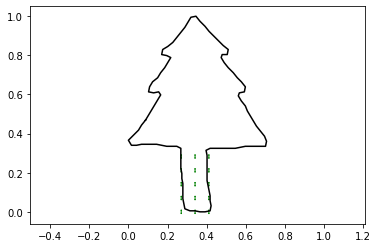

In [38]:
ax = plt.subplot()
dm.Utilities.plot_C_arrows(ax, points_growth, C, R=rot_growth, c_index=3, color='green', scale=0.05)
plt.plot(source[:, 0].numpy(), source[:, 1].numpy(), color='black')
plt.axis('equal')
plt.show()

In [39]:
scale_growth = 0.05
coeff_growth = 1.
nu = 0.001
#growth = dm.DeformationModules.ImplicitModule1(
#    2, points_growth.shape[0], scale_growth, C, coeff=coeff_growth, coeffcont=100., nu=nu,
#    gd=(points_growth, rot_growth))
growth = dm.DeformationModules.ImplicitModule1(
    2, points_growth.shape[0], scale_growth, C, coeff=coeff_growth, nu=nu,
    gd=(points_growth, rot_growth))

In [43]:
#%matplotlib qt5
C1 = torch.zeros(points_growth.shape[0], 2, 3)
C1[indi_growth_left, 0, 0] = 1.
C1[indi_growth_right, 0, 1] = 1.
C1[indi_growth_main, 0, 2] = 1.
C1[indi_growth_main, 1, 2] = 1.

NameError: name 'indi_growth_left' is not defined

In [ ]:
points_growth1 = points_growth.clone().detach().requires_grad_()

In [33]:
rot_growth1 = torch.stack([dm.Utilities.rot2d(0.)]*points_growth.shape[0], axis=0)

In [34]:
scale_growth1 = 0.2
coeff_growth1 = 1.
nu1 = 0.001
#growth = dm.DeformationModules.ImplicitModule1(
#    2, points_growth.shape[0], scale_growth, C, coeff=coeff_growth, coeffcont=100., nu=nu,
#    gd=(points_growth, rot_growth))
growth1 = dm.DeformationModules.ImplicitModule1(
    2, points_growth.shape[0], scale_growth1, C1, coeff=coeff_growth1, nu=nu1,
    gd=(points_growth1, rot_growth1))

In [40]:
rotation = dm.DeformationModules.LocalRotation(2, 2., gd=torch.tensor([[0., 0.]]).requires_grad_())

In [41]:
global_translation = dm.DeformationModules.GlobalTranslation(2)

In [42]:
source_deformable = dm.Models.DeformablePoints(source)
target_deformable = dm.Models.DeformablePoints(target)

In [43]:
sigmas_varifold = [0.05, 1.]
attachment = dm.Attachment.VarifoldAttachment(2, sigmas_varifold)

In [44]:

def rot2d_vec(thetas):
    assert len(thetas.shape) == 1
    sin = torch.sin(thetas)
    cos = torch.cos(thetas)

    return torch.stack([torch.stack([cos, -sin], dim=1),
                        torch.stack([sin, cos], dim=1)], dim=2)


In [45]:
def precompute(init_manifold, modules, parameters):
    basis = rot2d_vec(parameters['angles']['params'][0][:, 0])
    init_manifold[3].gd = (init_manifold[3].gd[0], basis)

    #basis = rot2d_vec(parameters['angles']['params'][1][:, 0])
    #init_manifold[4].gd = (init_manifold[4].gd[0], basis)

In [46]:
angles = torch.zeros(points_growth.shape[0], 1, requires_grad=True)
#angles1 = torch.zeros(points_growth.shape[0], 1, requires_grad=True)

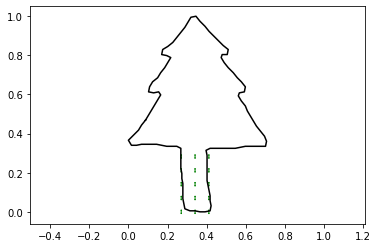

In [47]:
#rot_g = rot2d_vec(angles[:,0])
ax = plt.subplot()
dm.Utilities.plot_C_arrows(ax, points_growth, C, R=rot_growth.detach(), c_index=3, color='green', scale=0.05)
plt.plot(source[:, 0].numpy(), source[:, 1].numpy(), color='black')
plt.axis('equal')
plt.show()

In [48]:
modelgrowth = dm.Models.RegistrationModel([source_deformable], [global_translation, rotation, growth], [attachment], fit_gd=[False], lam=10.)
#modelgrowth = dm.Models.RegistrationModel([source_deformable], [global_translation, rotation, growth], [attachment], fit_gd=[False], lam=10.,precompute_callback=precompute, other_parameters={'angles': {'params': [angles]}})

In [49]:
shoot_solver = 'euler'
shoot_it = 10

costs = {}
fitter = dm.Models.Fitter(modelgrowth, optimizer='torch_lbfgs')
# fitter = dm.Models.Fitter(model, optimizer='scipy_l-bfgs-b')
fitter.fit([target_deformable], 20, costs=costs, options={'shoot_solver': shoot_solver, 'shoot_it': shoot_it, 'line_search_fn': 'strong_wolfe'})


Starting optimization with method torch LBFGS
Initial cost={'deformation': tensor(0.), 'attach': tensor(5.7400)}
Time: 89.61159535299885
Iteration: 0
Costs
deformation=0.024741357872139935
attach=2.614059298732573
Total cost=2.638800656604713
Time: 174.24396635000085
Iteration: 1
Costs
deformation=0.02713611570298742
attach=2.592707189653034
Total cost=2.6198433053560213
Time: 253.6339789900012
Iteration: 2
Costs
deformation=0.004397541220913723
attach=2.5899322406073777
Total cost=2.5943297818282915
Time: 331.9371486000018
Iteration: 3
Costs
deformation=0.0006290766554514448
attach=2.5861721293385864
Total cost=2.5868012059940377
Time: 422.96133909200216
Iteration: 4
Costs
deformation=0.00048125675258775763
attach=2.5831988761801106
Total cost=2.5836801329326984
Time: 523.520461234999
Iteration: 5
Costs
deformation=0.001154427837966598
attach=2.579044635088281
Total cost=2.5801990629262477
Time: 624.0259217589992
Iteration: 6
Costs
deformation=0.0014391949913764182
attach=2.5778754171

In [50]:
intermediates = {}
with torch.autograd.no_grad():
    deformed_source = modelgrowth.compute_deformed(shoot_solver, shoot_it, intermediates=intermediates)[0][0]


(-0.08995662897283371,
 0.7441017442368016,
 -0.0603879254090087,
 1.0504946631147147)

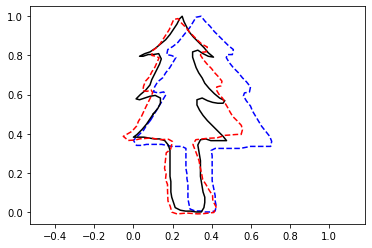

In [51]:
plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], '--b')
plt.plot(target.detach().numpy()[:,0], target.detach().numpy()[:,1], 'k')
plt.plot(deformed_source.detach().numpy()[:,0], deformed_source.detach().numpy()[:,1], '--r')
plt.axis('equal')

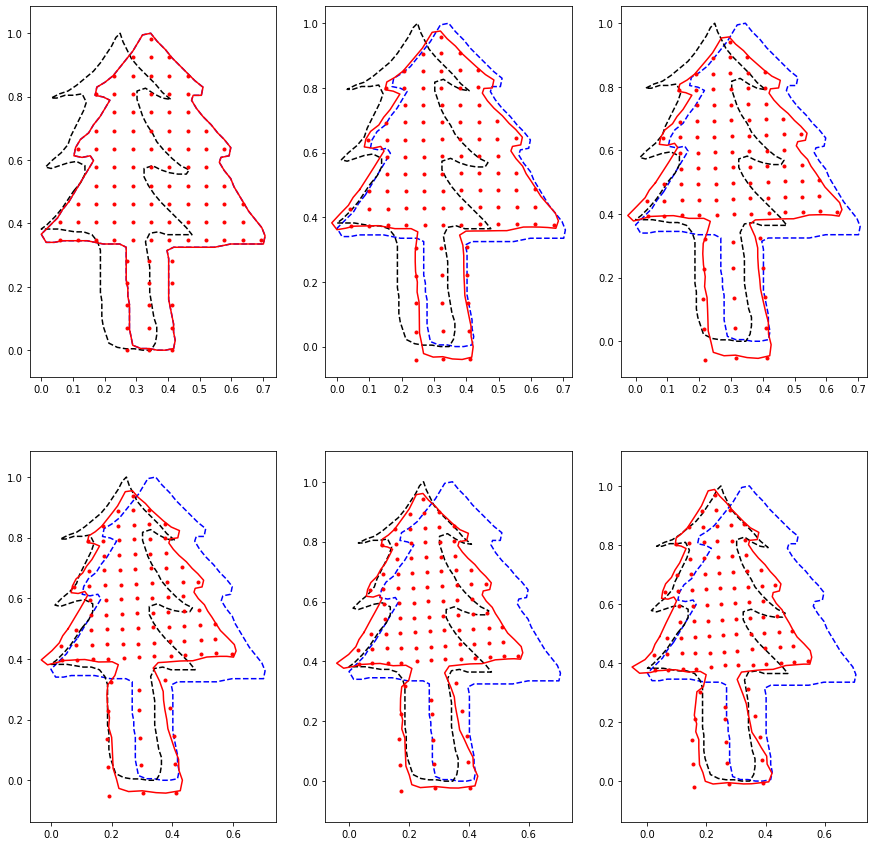

In [52]:
f = plt.figure(figsize=(15,15))
for i in range(6):
    ax = f.add_subplot(2,3,i+1)
    #if i<5:
    #    #print(intermediates['controls'][2*i][3])
    plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], '--b')
    plt.plot(target.detach().numpy()[:,0], target.detach().numpy()[:,1], '--k')
    plt.plot(intermediates['states'][2*i].gd[0].detach().numpy()[:,0], intermediates['states'][2*i].gd[0].detach().numpy()[:,1], 'r')
    plt.plot(intermediates['states'][2*i].gd[3][0].detach().numpy()[:,0], intermediates['states'][2*i].gd[3][0].detach().numpy()[:,1], '.r')
    plt.axis('equal')

In [53]:
ind_subj_target

7

In [54]:
pickle.dump(modelgrowth.init_manifold, open( "/home/gris/Results/ImplicitModules/Tree/init_manifold" + str(ind_subj_source) + '_' + str(ind_subj_target) + ".p", "wb" ) )


In [55]:
for i in range(10):
    print(intermediates['controls'][i][3])

tensor([-1.2068e-03, -4.1288e-01,  6.4147e-01,  1.3655e+00])
tensor([-0.1267, -0.4051,  0.8215,  1.1009])
tensor([-0.2205, -0.3794,  1.0101,  1.1177])
tensor([-0.2893, -0.3122,  1.4421,  0.8722])
tensor([-0.3210, -0.1559,  1.9651,  0.2025])
tensor([-0.2872,  0.0337,  2.0067, -0.9495])
tensor([-0.2327,  0.0271,  1.4109, -1.0158])
tensor([-0.2286,  0.1445,  0.9193, -0.9442])
tensor([-0.1912,  0.3011,  0.7580, -0.7742])
tensor([-0.1170,  0.4332,  0.5557, -0.5850])


In [106]:
for i in range(10):
    print(intermediates['controls'][i][2])

tensor(0.1060)
tensor(0.1026)
tensor(0.0996)
tensor(0.0969)
tensor(0.0943)
tensor(0.0923)
tensor(0.0889)
tensor(0.0825)
tensor(0.0698)
tensor(0.0487)


In [41]:
angles[:,0] #- angles1[:,0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<SelectBackward>)

In [51]:
rot_opt = rot2d_vec(angles1[:,0])

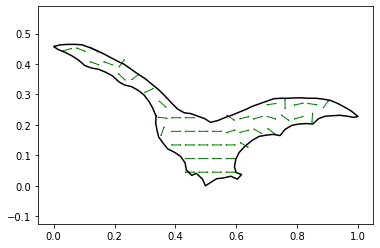

In [52]:


ax = plt.subplot()
dm.Utilities.plot_C_arrows(ax, points_growth, C, R=rot_opt.detach(), c_index=0, color='green', scale=0.05)
plt.plot(source[:, 0].numpy(), source[:, 1].numpy(), color='black')
plt.axis('equal')
plt.show()

In [133]:
sum([intermediates['controls'][i][3] for i in range(10)])

tensor([-1.4724, -0.9232, -0.8754])

In [134]:
for i in range(10):
    print(intermediates['controls'][i][3])

tensor([-0.1470, -0.0912, -0.0962])
tensor([-0.1509, -0.0921, -0.0954])
tensor([-0.1545, -0.0929, -0.0945])
tensor([-0.1570, -0.0937, -0.0931])
tensor([-0.1578, -0.0942, -0.0912])
tensor([-0.1559, -0.0943, -0.0887])
tensor([-0.1510, -0.0937, -0.0855])
tensor([-0.1431, -0.0925, -0.0816])
tensor([-0.1331, -0.0906, -0.0771])
tensor([-0.1221, -0.0881, -0.0722])


In [135]:
# We extract the modules of the models and fill the right manifolds.
silent = dm.DeformationModules.SilentBase(copy.copy(modelgrowth.init_manifold.clone().manifolds[0]), label='sil')
modules = dm.DeformationModules.CompoundModule(copy.copy(modelgrowth.modules))
modules.manifold.fill(modelgrowth.init_manifold.clone(), copy=True)
deformation_grid = dm.DeformationModules.DeformationGrid(dm.Utilities.AABB.build_from_points(silent.manifold.gd).scale(1.2).squared(), [64, 64])
#translation = copy.copy(modelgrowth.modules[0])
#growth2 = copy.copy(modelgrowth.modules[1])

In [136]:
CompoundModule = dm.DeformationModules.CompoundModule([deformation_grid] + modules.modules)

In [137]:
# We construct the controls list we will give will shooting
controls = [[torch.tensor([]), torch.tensor([]), 0.*control[1], 0.*control[2], torch.tensor([0.*control[3][0], 1.*control[3][1], 0.*control[3][2]])] for control in intermediates['controls']]

In [138]:
intermediates_cont = {}
dm.HamiltonianDynamic.shoot(dm.HamiltonianDynamic.Hamiltonian(CompoundModule.modules), shoot_solver, shoot_it, controls=controls, intermediates=intermediates_cont)

In [139]:
growth_deformed_source = silent.manifold.gd.detach()
growth_deformed_grid = deformation_grid.togrid()

tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)


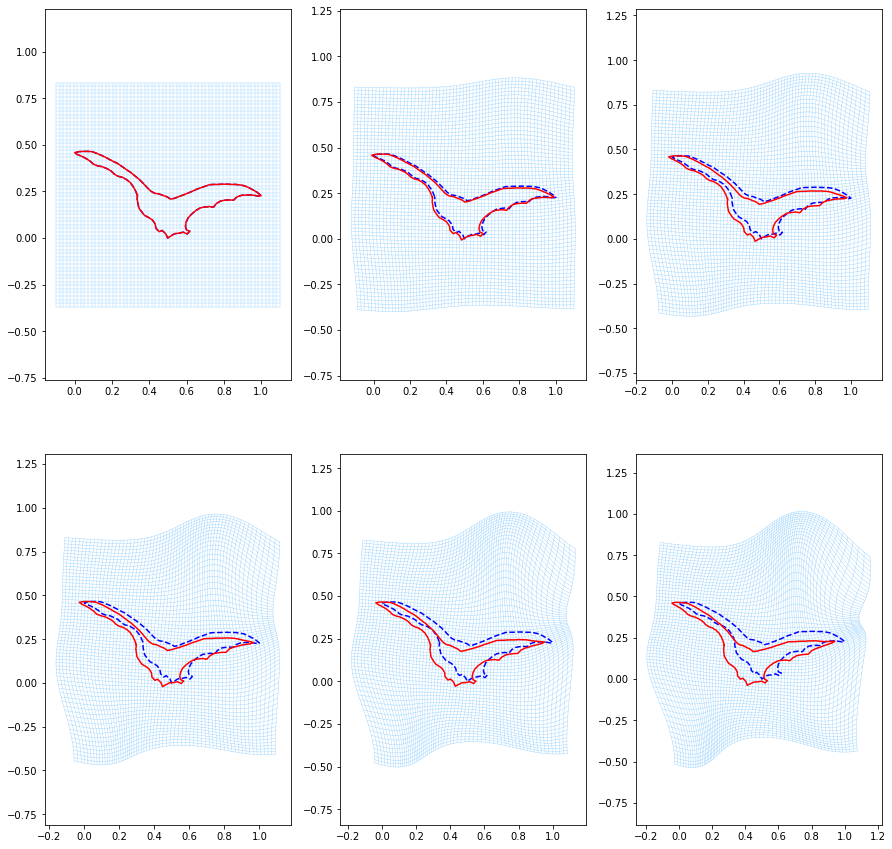

In [140]:
f = plt.figure(figsize=(15,15))
for i in range(6):
    ax = f.add_subplot(2,3,i+1)
    if i<5:
        print(intermediates_cont['controls'][2*i][3])
    deformation_grid_t = dm.DeformationModules.DeformationGrid(dm.Utilities.AABB.build_from_points(silent.manifold.gd).scale(1.2).squared(), [64, 64])
    deformation_grid_t.manifold.fill_gd(intermediates_cont['states'][2*i].gd[0].detach())
    growth_deformed_grid_t = deformation_grid_t.togrid()
    dm.Utilities.plot_grid(ax, growth_deformed_grid_t[0], growth_deformed_grid_t[1], color='xkcd:light blue', lw=0.4)
    plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], '--b')
    #plt.plot(target.detach().numpy()[:,0], target.detach().numpy()[:,1], '--k')
    plt.plot(intermediates_cont['states'][2*i].gd[1].detach().numpy()[:,0], intermediates_cont['states'][2*i].gd[1].detach().numpy()[:,1], 'r')
    plt.axis('equal')

tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(-0.)


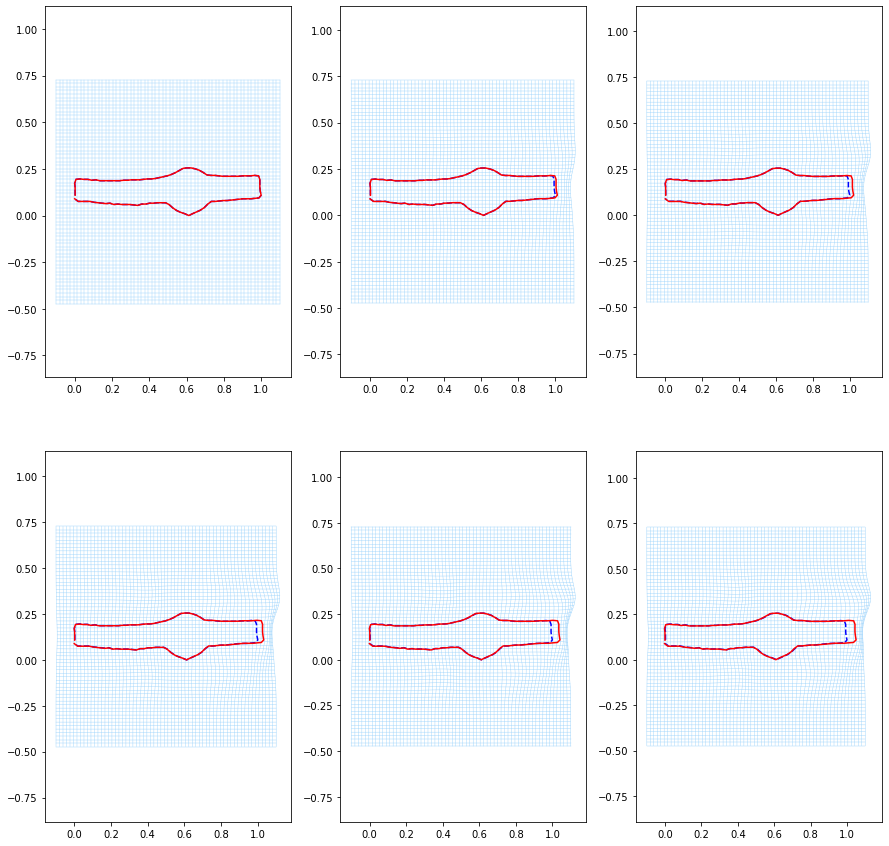

In [81]:
f = plt.figure(figsize=(15,15))
for i in range(6):
    ax = f.add_subplot(2,3,i+1)
    if i<5:
        print(intermediates_cont['controls'][2*i][3])
    deformation_grid_t = dm.DeformationModules.DeformationGrid(dm.Utilities.AABB.build_from_points(silent.manifold.gd).scale(1.2).squared(), [64, 64])
    deformation_grid_t.manifold.fill_gd(intermediates_cont['states'][2*i].gd[0].detach())
    growth_deformed_grid_t = deformation_grid_t.togrid()
    dm.Utilities.plot_grid(ax, growth_deformed_grid_t[0], growth_deformed_grid_t[1], color='xkcd:light blue', lw=0.4)
    plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], '--b')
    #plt.plot(target.detach().numpy()[:,0], target.detach().numpy()[:,1], '--k')
    plt.plot(intermediates_cont['states'][2*i].gd[1].detach().numpy()[:,0], intermediates_cont['states'][2*i].gd[1].detach().numpy()[:,1], 'r')
    plt.axis('equal')

(-0.2099575578392855,
 1.3644548670464338,
 -0.5323633347340097,
 0.7877051311809289)

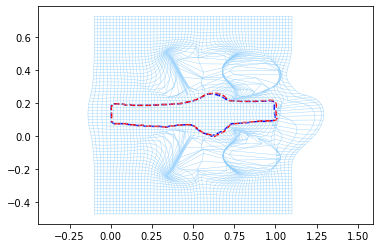

In [75]:
#%matplotlib qt5
ax = plt.subplot(1, 1, 1)
plt.plot(source.detach().numpy()[:, 0], source.detach().numpy()[:, 1], '--b')
#plt.plot(target.detach().numpy()[:,0], target.detach().numpy()[:,1], 'k')
plt.plot(growth_deformed_source[:, 0].numpy(), growth_deformed_source[:, 1].numpy(), '--r')
dm.Utilities.plot_grid(ax, growth_deformed_grid[0], growth_deformed_grid[1], color='xkcd:light blue', lw=0.4)
plt.axis('equal')


# Working on images

In [11]:
source_image = dm.Utilities.load_greyscale_image( path_datafiles + 'Images/watch01.png', origin='lower')
target_image = dm.Utilities.load_greyscale_image( path_datafiles + 'Images/watch03.png', origin='lower')

In [34]:
source_image.shape

torch.Size([202, 500])

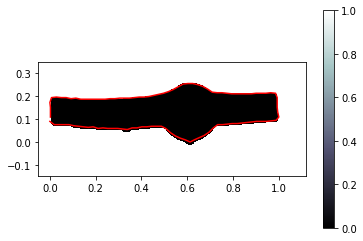

In [12]:

extent_source = dm.Utilities.AABB( -0.05, 1.12,-0.15, 0.35)

plt.imshow(source_image.numpy(), origin='lower', cmap='bone', extent=extent_source.totuple())
plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], 'r')
plt.colorbar()

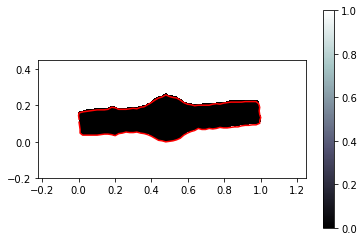

In [13]:
extent_target = dm.Utilities.AABB( -0.22, 1.25,-0.2, 0.45)
target_image = dm.Utilities.load_greyscale_image( path_datafiles + 'Images/watch11.png', origin='lower')
plt.imshow(target_image.numpy(), origin='lower', cmap='bone', extent=extent_target.totuple())
plt.plot(target.detach().numpy()[:,0], target.detach().numpy()[:,1], 'r')
plt.colorbar()

In [14]:
indi_left0 = range(0, 28)
indi_left1 = range(80, 104)
indi_right = range(37, 69)

part_left = np.concatenate([source[indi_left1, :], source[indi_left0, :]], axis = 0)
part_right = source[indi_right, :]

In [15]:
aabb_source = dm.Utilities.AABB.build_from_points(source)
points_growth = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_source, 500, shape=source)
points_growthleft = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_source, 500, shape=torch.tensor(part_left), intersect=True)
points_growthright = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_source, 500, shape=torch.tensor(part_right), intersect=True)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [16]:
indi_growth_left = range(0,points_growthleft.shape[0] +2)
indi_growth_right = range(points_growth.shape[0]-points_growthright.shape[0], points_growth.shape[0])

(-0.05, 1.05, -0.012766, 0.268086)

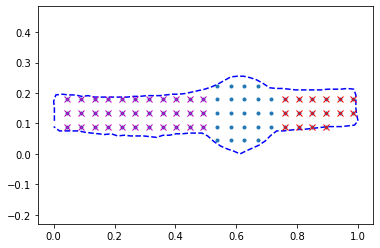

In [17]:
plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], '--b')
plt.plot(points_growth[:,0], points_growth[:,1], '.')
plt.plot(points_growth[indi_growth_left,0], points_growth[indi_growth_left,1], 'xm')
plt.plot(points_growth[indi_growth_right,0], points_growth[indi_growth_right,1], 'xr')
plt.axis('equal')

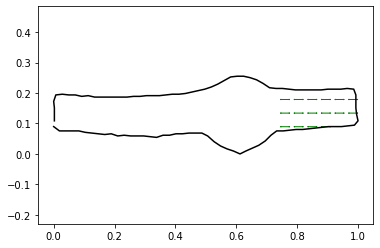

In [18]:
#%matplotlib qt5
C = torch.zeros(points_growth.shape[0], 2, 2)
C[indi_growth_left, 0, 0] = 1.
C[indi_growth_right, 0, 1] = 1.

ax = plt.subplot()
dm.Utilities.plot_C_arrows(ax, points_growth, C, c_index=1, color='green', scale=0.05)
plt.plot(source[:, 0].numpy(), source[:, 1].numpy(), color='black')
plt.axis('equal')
plt.show()


In [19]:
rot_growth = torch.stack([dm.Utilities.rot2d(0.)]*points_growth.shape[0], axis=0)
scale_growth = 0.1
coeff_growth = 1.
nu = 0.001
growth = dm.DeformationModules.ImplicitModule1(
    2, points_growth.shape[0], scale_growth, C, coeff=coeff_growth, nu=nu,
    gd=(points_growth, rot_growth))

In [20]:
global_translation = dm.DeformationModules.GlobalTranslation(2)

In [21]:
source_deformable = dm.Models.DeformableImage(source_image, output='bitmap',
                                              extent=extent_source)
target_deformable = dm.Models.DeformableImage(target_image, output='bitmap',
                                              extent=extent_target)

In [22]:

source_image_deformable = dm.Models.DeformableImage(source_image, output='bitmap',
                                              extent=extent_source)
target_image_deformable = dm.Models.DeformableImage(target_image, output='bitmap',
                                              extent=extent_target)


In [23]:
attachment_image = dm.Attachment.EuclideanPointwiseDistanceAttachment()

In [31]:
target_image_deformable.geometry[0].shape

torch.Size([224, 520])

In [30]:
source_image_deformable.geometry[0].shape

torch.Size([202, 500])

In [26]:
attachment_image(source_image_deformable.geometry, target_image_deformable.geometry)

RuntimeError: The size of tensor a (500) must match the size of tensor b (520) at non-singleton dimension 1

In [81]:
modelgrowth_image = dm.Models.RegistrationModel([source_image_deformable], [global_translation, growth], [attachment_image], fit_gd=[False], lam=100.)

In [83]:
shoot_solver = 'euler'
shoot_it = 10

costs = {}
fitter = dm.Models.Fitter(modelgrowth_image, optimizer='torch_lbfgs')
# fitter = dm.Models.Fitter(model, optimizer='scipy_l-bfgs-b')
fitter.fit(target_image_deformable, 20, costs=costs, options={'shoot_solver': shoot_solver, 'shoot_it': shoot_it, 'line_search_fn': 'strong_wolfe'})

KeyboardInterrupt: 